In [2]:
# import of standard python libraries
import numpy as np
import os, sys
import time
import corner
import astropy.io.fits as pyfits

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from astropy.cosmology import FlatLambdaCDM # TODO: replace with lenstronomy cosmo


In [3]:
sys.path.append('/home/jwp/stage/sl/lenstronomy')
import lenstronomy
lenstronomy.__file__

'/home/jwp/stage/sl/lenstronomy/lenstronomy/__init__.py'

In [4]:
# Image specifics
sigma_bkg = 0.05  #  background noise per pixel (Gaussian)
exp_time = 100.0  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

Filename: data/rung1/code1/f160w-seed101/drizzled_image/lens-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (99, 99)   float32   
None
3721.285408139229


/home/jwp/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


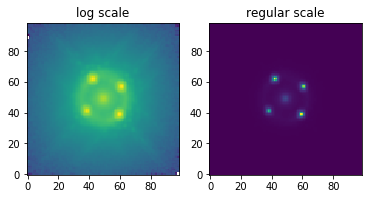

In [56]:
rung_fits_path = "data/rung1/code1/f160w-seed101/drizzled_image/lens-image.fits"
answers_path = 'data/rung1_open_box/code1/f160w-seed101/lens_all_info.txt'


hdul = pyfits.open(rung_fits_path)
print(hdul.info())
img = hdul['PRIMARY'].data
print(sum(sum((img))))
plt.subplot(1, 2, 1)
plt.imshow(np.log(img), origin='lower right')
plt.title("log scale")
plt.subplot(1, 2, 2)
plt.imshow(img,  origin='lower right')
plt.title("regular scale")
plt.show()


In [4]:
 with open(answers_path) as f:
    for line in f:
        print(line)

Unit:

	Length in arcsecond scale, 'phi_G' is Angle in radian system start from x axis anticlockwise.

Cosmological para

	FlatLambdaCDM, with Om=0.27 and H0: 74.151km/s/Mpc

Pixel size is 0.13'' and 0.08'' before and after drizzle

Time delay distance: TD_distance=(1+z_l)*D_l*D_s/D_ls:8406.369Mpc

Time delay of BCD - A :

	array([ 33.338,  19.063,  -2.23 ])days

Zeropoint of filter (AB system): 	25.9463

Lens/Source redshift:	[1.041, 2.251]

Lens mass model:

	SPEMD:{'theta_E': 1.133, 'q': 0.709, 'center_x': 0, 'center_y': 0, 'phi_G': 0.539, 'gamma': 2.063}

	Shear: 	({'e1': 0.023, 'e2': 0.011}, {'b': 0.026, 'phi_G': 1.793})'	 Note that e1=-b*cos(2*phi_G); e2=-b*sin(2*phi_G)'

Lens light: 

	{'q': 0.95, 'amp_sersic': 0.093, 'n_sersic': 3.371, 'phi_G': 0.559, 'mag_sersic': 18.033, 'R_sersic': 0.89}

Source light in source plane: 

	Host galaxy name: NGC4639	CenterPos: array([ 0.02,  0.02])

	Host mag: 21.291 mag	Host R_eff: 0.333 arcsec			 'The mag and R_eff are set by galfit value'

A

In [6]:
from lenstronomy.Analysis.lens_properties import LensProp

In [61]:
def e1e1_from_qphi(q, phi):
    e = (1 - q)/(1 + q)
    e1 = np.cos(2.0*phi)
    e2 = np.sin(2.0*phi)
    return e1, e2

from lenstronomy.Util import param_util
param_util.phi_q2_ellipticity(q=0.079, phi=0.539)

(0.40381568157061654, 0.7520049391170354)

In [62]:
H0_samples = []
H0_weights = []
N = 10
r_eff = 0.89

z_lens = 1.041
z_src = 2.251

# lens mass
e1_lens, e2_lens = e1e1_from_qphi(q=0.709, phi=2.063)
kwargs_spemd = {'theta_E': 1.133, 'center_x': 0, 'center_y': 0,
                'e1': e1_lens, 'e2': e2_lens, 'gamma': 2.063,}
kwargs_shear = {'gamma_ext': 0.026, 'psi_ext': 1.793}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# lens light
e1_lens_light, e2_lens_light = e1e1_from_qphi(q=0.95, phi=0.559)
kwargs_sersic_lens = {'amp':  0.093, 'R_sersic': 0.89, 'n_sersic': 3.371 , 
                      'e1': e1_lens_light, 'e2': e2_lens_light, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic_lens]

# source host
e1_src, e2_src = e1e1_from_qphi(q=0.69, phi=np.deg2rad(159.9))
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 7.7, 'n_sersic': 1.32,
                        'e1': e1_src, 'e2': e2_src,
                        'center_x': 0.02, 'center_y': 0.02}
kwargs_source = [kwargs_sersic_source]

# unlensed agn
kwargs_ps = [{'ra_source': 0.02, 'dec_source': 0.02, 'point_amp': 75.155}] 

measured_vd = 338.685
measured_vd_sig = 16.42

measured_td = [ 31.239,  17.935,  -2.159]
measured_td_sig = [ 0.31,  0.25,  0.25]

kwargs_model = {'lens_model_list': ['SPEMD', 'SHEAR_GAMMA_PSI'],
                'lens_light_model_list': ['SERSIC_ELLIPSE'],
                'source_light_model_list': ['SERSIC_ELLIPSE'],
                'point_source_model_list': ['SOURCE_POSITION'],
                 }

r_eff = kwargs_sersic_lens['R_sersic']

for n in range(N):
    h0 = np.random.uniform(low=50, high=90)
    beta_ani = np.random.uniform(low=0.5*r_eff, high=5.0*r_eff)
    k_ext = np.random.normal(loc=0, scale=0.025)
    
    cosmo = FlatLambdaCDM(H0=h0, Om0=0.27, Ob0=0.0)
    lp = LensProp(z_lens, z_src, kwargs_model, cosmo=cosmo)
    
    vd = lp.velocity_dispersion(kwargs_lens, r_eff, 1.0, 1.0, 0.6, aniso_param=1.0, num_evaluate=1000)
    ll_vd = -0.5*(vd - measured_vd)**2.0/measured_vd_sig - np.log(measured_vd_sig)

    td = lp.time_delays(kwargs_lens, kwargs_ps, kappa_ext=k_ext)
    print(td)

    ll_td = 0.0
    for i in range(3):
        ll_td += -0.5*(td - measured_td[i])**2.0/measured_td_sig[i] - np.log(measured_td_sig[i])
    pass
    log_w = ll_vd + ll_td
    w = np.exp(log_w)

    H0_samples.append(h0)
    H0_weights.append(w)

[0.00137437]


TypeError: attribute of type 'int' is not callable

In [78]:
H0_samples = []
H0_weights = []
N = 20
r_eff = 0.89

z_lens = 1.041
z_src = 2.251

# lens mass
e1_lens, e2_lens = param_util.phi_q2_ellipticity(q=0.709, phi=0.539)
kwargs_spemd = {'theta_E': 1.133, 'center_x': 0, 'center_y': 0,
                'e1': e1_lens, 'e2': e2_lens, 'gamma': 2.063,}
kwargs_shear = {'gamma_ext': 0.026, 'psi_ext': 1.793}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# lens light
e1_lens_light, e2_lens_light = param_util.phi_q2_ellipticity(q=0.95, phi=0.559)
kwargs_sersic_lens = {'amp':  0.093, 'R_sersic': 0.89, 'n_sersic': 3.371 , 
                      'e1': e1_lens_light, 'e2': e2_lens_light, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic_lens]

# unlensed agn
kwargs_ps = [{'ra_image': [0.831, -0.86 ,  0.928, -0.541], 
              'dec_image': [-0.81 , -0.623,  0.62 ,  1.027], 'point_amp': 75.155}] 

measured_vd = 338.685
measured_vd_sig = 16.42

measured_td = np.array([ 31.239,  17.935,  -2.159])
measured_td_sig = np.array([ 0.31,  0.25,  0.25])

kwargs_model = {'lens_model_list': ['SPEMD', 'SHEAR_GAMMA_PSI'],
                'lens_light_model_list': ['SERSIC_ELLIPSE'],
                'source_light_model_list': ['SERSIC_ELLIPSE'],
                'point_source_model_list': ['LENSED_POSITION'],
                 }

r_eff = kwargs_sersic_lens['R_sersic']

for n in range(N):
    #h0 = np.random.uniform(low=50, high=90)
    h0 = 74.151
    #k_ext = np.random.normal(loc=0, scale=0.025)
    k_ext = 0.0677
    
    cosmo = FlatLambdaCDM(H0=h0, Om0=0.27, Ob0=0.0)
    lp = LensProp(z_lens, z_src, kwargs_model, cosmo=cosmo)
    
    vd = lp.velocity_dispersion(kwargs_lens, r_eff, 1.0, 1.0, 0.6, aniso_param=1.0/r_eff, num_evaluate=1000)
    vd = float(vd)
    ll_vd = -0.5*(vd - measured_vd)**2.0/measured_vd_sig**2.0 - 0.5*np.log(2.0*np.pi*measured_vd_sig**2.0)

    td_abs = np.array(lp.time_delays(kwargs_lens, kwargs_ps, kappa_ext=k_ext))
    td_rel = td_abs[1:] - td_abs[0]
    
    ll_td = np.sum(-0.5*(td_rel - measured_td)**2.0/measured_td_sig**2.0 -0.5*np.log(2.0*np.pi*measured_td_sig**2.0))
    
    print(td_rel)
    print(ll_vd, ll_td)
    
    log_w = ll_vd + ll_td
    w = np.exp(log_w)

    H0_samples.append(h0)
    H0_weights.append(w)
    
print("Samples obtained")
    

[46.67971545 30.08373384 -4.23623024]
-3.9516795447327935 -2454.5222608525924
[46.67971545 30.08373384 -4.23623024]
-3.9230261154840647 -2454.5222608525924
[46.67971545 30.08373384 -4.23623024]
-3.9420956342610776 -2454.5222608525924
[46.67971545 30.08373384 -4.23623024]
-3.9318041167352615 -2454.5222608525924
[46.67971545 30.08373384 -4.23623024]
-3.9390666554929616 -2454.5222608525924


KeyboardInterrupt: 

/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., nan]),
 array([51.56859726, 52.61873852, 53.66887978, 54.71902104, 55.7691623 ,
        56.81930356, 57.86944482, 58.91958608, 59.96972734, 61.0198686 ,
        62.07000986, 63.12015112, 64.17029238, 65.22043364, 66.2705749 ,
        67.32071616, 68.37085741, 69.42099867, 70.47113993, 71.52128119,
        72.57142245, 73.62156371, 74.67170497, 75.72184623, 76.77198749,
        77.82212875, 78.87227001, 79.92241127, 80.97255253, 82.02269379,
        83.07283505]),
 <a list of 30 Patch objects>)

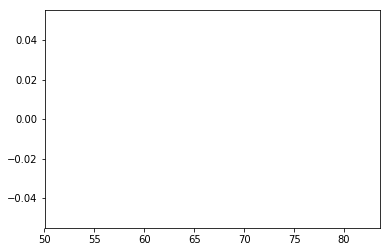

In [68]:
plt.hist(H0_samples, bins=30, weights=H0_weights, density=True)

In [23]:

print(kwargs_ps)
print(kwargs_lens)
lp.lens_analysis.PointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

[{'dec_source': 0.02, 'ra_source': 0.02, 'point_amp': 75.155}]
[{'e2': 0.881013386870012, 'center_x': 0, 'theta_E': 1.133, 'e1': 0.47309133595515224, 'gamma': 2.063, 'center_y': 0}, {'gamma_ext': 0.026, 'psi_ext': 1.793}]


([array([0.01932001])], [array([0.02025963])])